# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [6]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

* The Smartcab does not move at all during the simulation.
* The driving agent receives positive rewards for idling at a red light and negative rewards for idling at a green light.  The negative rewards have almost twice the magnitude of the positive rewards.  
* The light changing dictates the sign of the reward.  The rewards for idling at a red light are posiitive (as this is a thing the agent should do) and the rewards for idling at a green light are negative (as this is a thing the agent should not do).

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

* In the `agent.py` Python file, three flags that can be set for the `LearningAgent` are `learning`, `epsilon`, and `alpha`.
    * `learning` is a boolean variable that controls whether the agent is in learning mode or not.  If `True`, the agent will be learning a policy as it goes and following that policy as part of Q-learning (though it can still choose a random action with probability `epsilon`).  If `False`, the agent will choose a random action to take at each state.
    * `epsilon` is the random exploration factor, a value from 0.0 to 1.0.  This controls how likely it is that the agent takes a random action while in `learning` mode.  This will be decayed over time as part of the `reset` function (which makes sense, because we are more confident in our policy as we've seen more states and actions).
    * `alpha` is the learning rate for the Q-learning update procedure, a value from 0.0 to 1.0.  In our equation for the Q value-iteration update algorithm, `alpha` controls how much of our new reward for taking an action adjusts the original Q value.  See the equation from [Wikipedia](https://en.wikipedia.org/wiki/Q-learning) below.
    ![Q Equation](https://wikimedia.org/api/rest_v1/media/math/render/svg/390d024c2ee2a2c2f709642401a3a7b44f7b2e4e)
* In the `environment.py` Python file, the Environment class function `act` is called when an agent performs an action.
* In the `simulator.py` Python file, the difference between the `render_text()` function and the `render()` function is that `render_text()` is the non-GUI version that will render the text in the terminal while `render()` is the GUI version that render the text in the display of the simulation.
* In the `planner.py` Python file, the `next_waypoint()` function will consider the East-West direction first.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


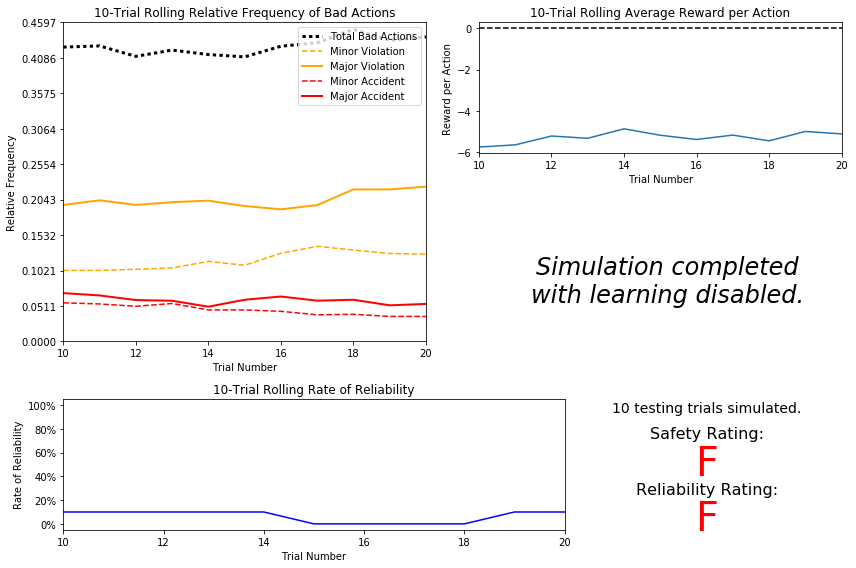

In [7]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

Overall, this agent performs terribly, getting a Safety and Reliability Rating of F!  Let's discuss the cause of this.

* The driving agent makes bad decisions 40% to 45% of the time.  About 10% of the time the agent causes accidents, both minor and major, and violates traffic rules 30% of the time.
* The driving agent has a very low reliability, hovering between 5% and 10%.  However, given that the agent is driving randomly, this poor rate of reliability makes sense as it is unlikely to reach its destination by chance.
* The agents mostly receives negative rewards for its actions with an average reward per action of around -5.  The few positive actions it takes are heavily penalized by the many negative actions it takes.
* As the number of trials increases, the outcome of results doesn't change significantly.  That makes sense though, because this simulation was completed with learning disabled.  Since random actions are chosen, there is nothing to learn and improve.
* This Smartcab would definitely not be safe enough nor reliable enough for its passengers.  It often makes bad actions and is not reliable.  

Overall, the performance of this driving agent is not surprising since it is taking random actions and not actually learning anything.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

* The features `waypoint`, `light`, and `oncoming` are most relevant for learning both **safety** and **efficiency**.  The feature `waypoint` helps the Smartcab understand where it is going, helping with **efficiency**.  The feature `light` helps with **safety**, letting the Smartcab know when it's appropriate to make an action vs staying in the same place.  The feature `oncoming` helps with **safety**, letting the Smartcab know whether the other car that is moving will prevent it from turning.
* The features `left`, `right`, and `deadline` were not chosen, because they do not provide critical information for making the next decision.  When a Smartcab is at an intersection and the `light` is red, the Smartcab should not be moving, so the cars to the `left` and `right` do not really matter.  It is not until the `light` is green that the Smartcab can move.  In this case, the cars to the `left` and `right` should not be moving and thus, do not really matter.  So there are no situations that the `left` and `right` variables provide relevant information.  The `waypoint` feature provides information about where the Smartcab should head next.  This is regardless of how much time is left before the `deadline`.  Since our Smartcab cannot teleport and we want it to be safe, the `deadline` does not help in making the decision of which action to take next.  (You could imagine a real life driver would use this `deadline` to decide to take some illegal driving actions, such as running a red light or cutting off another car.  However, since we want our Smartcab to be safe, we will forgo these possibilities).

**Note**:  The above comments are based upon some assumptions about the simulation.  I am assuming that every intersection has a stoplight rather than a stop sign.  Since there is a stop light, we only need to know the information about cars that are governed by the same stop light color (i.e. only the cars oncoming, not left or right).  I am also assuming that the others cars obey the rules of the road and will stop at red lights.  These are valid assumptions for this simulation but not necessarily valid for a real world scenario.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

Using the features I selected from **Question 4** (`waypoint`, `light`, and `oncoming`), the size of the state space would be 24.  The `waypoint` variable can have three values:  `right`, `forward`, and `left`.  The `light` variable can have two values:  `green` and `red`.  The `oncoming` variable can have four values:  `right`, `forward`, `left`, and `None`.  Together, this makes 24 combinations of the features to get the various states.  Given the environment and how it is simulated, I think the driving agent could learn a policy for each possible state within a reasonable number of training trials.  It is likely to encounter all of these equally common states.

I considered adding the `deadline` to the state, but this creates too many states as the `deadline` changes with every time step.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

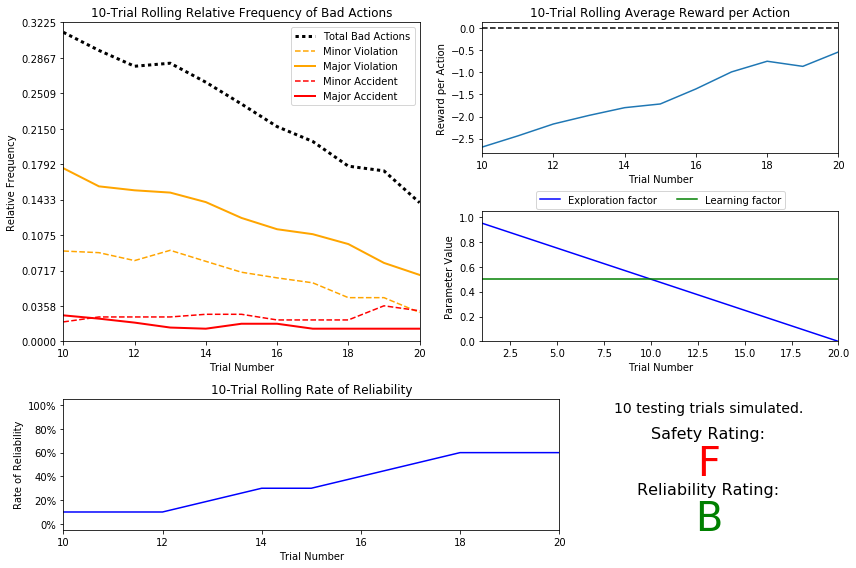

In [8]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

This Q-Learning agent did a much better job of learning and performed better overall.  This is evident in all of the charts, with the bad actions decreasing, the rate of reliability increasing, and the average reward per action increasing and getting closer to zero.  If you look through the Q table (`/logs/sim_default-learning.txt`), you can see many common sense actions the agent learned based upon the state.  I'll talk about a few.

```
('left', 'green', 'forward')
 -- forward : 1.14
 -- None : -3.40
 -- right : 0.00
 -- left : -17.21
 ```
 
 Here the agent wants to turn left, has a green light, but the oncoming car is planning to go forward.  If the agent were to take a left, it would cause an accident with the other car.  Correspondingly, the agent would incur a large, negative Q for taking a left.  It is rewarded most by continuing to go fowrd.
 
 ```
 ('forward', 'red', 'forward')
 -- forward : -4.80
 -- None : 0.98
 -- right : 0.39
 -- left : -7.77
 ```
 
 Here agent wants to go forward, has a red light, and the oncoming car is planning to go forward.  Since the light is red, the agent is heavily penalized (gets a large, negative reward) for making any illegal action, going forward or left and is most rewards for doing nothing or turning right, both valid options.
 
 Let's talk about a few more specific things.

* The basic driving agent and the default Q-Learning agent are much different.  The default Q-Learning agent learns a policy for given states that help it take the best action.  This is reflected in the charts as you see the number of bad actions decreases and the average reward per action increases.  The Q-Learning agent starts at a reliability rate close to that of the basic agent, but it quickly increases reliability.
* The driving agent required ~20 training trials before testing.  This makes sense, because our epsilon decay function was linear with a decrease of 0.05 each trial and the epsilon-tolerance was 0.05.  So at 20 trials, the epsilon would be less than the epsilon-tolerance.
* The decaying function I implemented for epsilon is accurately represented in the parameters panel.  It shows the epsilon decreasing linearly over time at a rate of 0.05 per trial.
* As the number of training trials increased, the number of bad actions decreased by approximately half.  As the number of training trials increased, the average reward per action increased.
* The reliability and safety of this agent is much better than the initial driving agent, but the safety is still at unacceptable levels (F!).

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

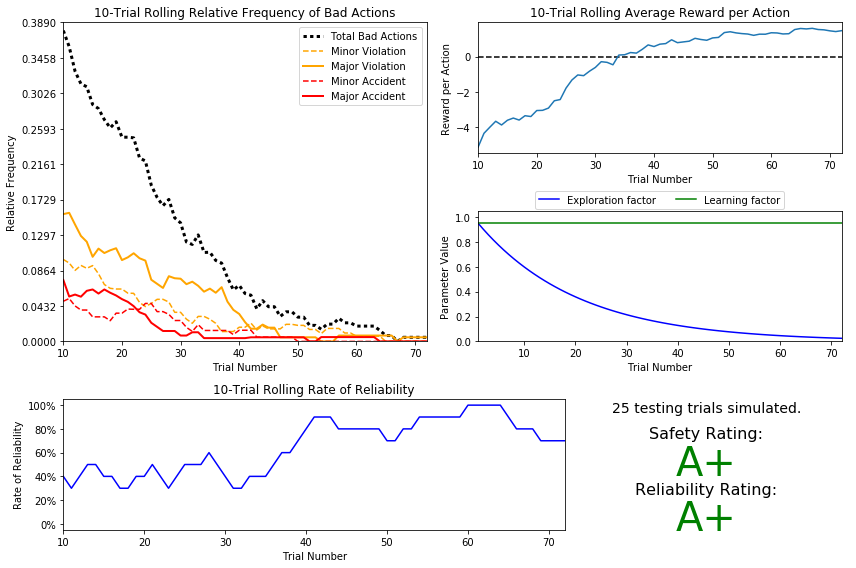

In [11]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv') 

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

This simulation worked much better than the previous two.  It increased the safety rating while also increasing the level of reliability.  This provides an experience that the users can be confident in.

* I used the exponential decay function for epsilon:  $\epsilon = a^{t}, \textrm{for } 0 < a < 1$ .  I chose this because I like the idea that epsilon will decay more gradually.
* 72 training periods were needed for the agent before beginning testing.  This makes sense because 0.95^72 = 0.02489, which is less than the epsilon tolerance of 0.025 that I set.
* I used an alpha of 0.95 because I wanted the model to learn more gradually rather than overcorrecting.  While this takes longer to learn, I think the benefit outweighs the training time in this case.  I used an epsilon-tolerance of 0.025 so that it would learn a bit longer and still had the chance of taking a few random actions.
* A lot of improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section.  This learner had a greatly improved Safety Rating of A+ and brought the 10-trial rolling average of accdients down to zero as seen in the top left panel.  Additionally, the average reward per action became positive, peaking at ~1.0 as seen in the top right panel.  The Reliability Rating improved to A+ with near perfect reliability.
* It seems that the Q-Learner results show that the driving agent successfully learned an appropriate policy.  This is evident in it's higher safety rating and reliability rating.  Additionally, we can examine some rules to see that the appropriate actions are taken.
```
('left', 'red', None)
 -- forward : -38.32
 -- None : 2.75
 -- right : 0.07
 -- left : -9.96
 ```
 In this case, the agent wants to go left, but the light is red.  It gets large, negative penalties for doing any action and gets a positive reward for doing nothing, the appropriate action.  Let's look at another part of the policy.
 ```
('left', 'green', 'forward')
 -- forward : -0.13
 -- None : -5.06
 -- right : 1.64
 -- left : -19.87
 ```
 Here, the agent wants to go left and the light is green, but a car is going forward from across the intersection.  Here, the agent has learned not to take a left (causing an accident) even though it wants to.  This shows the agent has learned to avoid accidents.  

* I am satisfied with the Safety and Reliability Ratings of the Smartcab.  The Safety Rating is perfect and Reliability Rating is perfect.  I would want to do further tests to see that these results continue to work well.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

For the following discussion, the state inputs are 

* `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
* `light`:  The status of the traffic light, `green`, or `red`
* `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
* `'left'`, the intended direction of travel for a vehicle to the left of the intersection from the *Smartcab*. Returns `None` if no vehicle is present.

The state vector is (`waypoint`, `light`, and `oncoming`).

1. The optimal policy for the smartcab in the given environment is as follows:
    * Look at the `light`.
    * If the `light` is `red`, the `waypoint` is `right` and there is no traffic coming from the `left`, the Smartcab turn to the `right`.
    * Otherwise, the smartcab should do nothing.
    * If the `light` is `green`, the `waypoint` is `left`, and the `oncoming` value is `forward`, the Smartcab will do nothing and wait to turn.
    * Othwerwise, the Smartcab will following the `waypoint`.
2. Looking at the `sim_improved-learning.txt` text file, most of the results of my improved Q-Learning algorithm seem to match this given policy.  However, I did not use the `left` variable in my original dataset and still achieved perfect results.  This may have been easier to achieve with the `left` variable, but this shows it can be done without it.  There are a few states where the policy is different than what would be expected from an optimal policy.
```
('left', 'green', 'forward')
 -- forward : -0.13
 -- None : -5.06
 -- right : 1.64
 -- left : -19.87
 ```
 In this case, the optimal policy says to wait for the car to pass so that you could then turn left.  However, in this case, the cab will turn right.
 ```
 ('right', 'green', 'right')
 -- forward : 1.73
 -- None : 0.00
 -- right : 0.00
 -- left : -18.57
 ```
 In this case, the optimal policy says to go right, but the Smartcab goes forward.  Other than few examples, many match the optimal policy.  But it's interesting that this policy achieves the desired outcome without being optimal.

3. The following are a few examples where my Smartcab learned the optimal policy.
```
('left', 'red', None)
 -- forward : -38.32
 -- None : 2.75
 -- right : 0.07
 -- left : -9.96
 ```
 Here, the Smartcab learned to do nothing on a `red` `light`.  It's even more interesting how negatively it is penalized for the incorrect actions, `forward` and `left`.  
 ```
 ('forward', 'green', None)
 -- forward : 1.82
 -- None : -4.48
 -- right : 0.29
 -- left : -0.63
 
 ('right', 'green', None)
 -- forward : -0.26
 -- None : -5.14
 -- right : 1.75
 -- left : 0.96
 ```
 In both of these states, the Smartcab learned to follow it's `waypoint` when there is no `oncoming` car and the `light` is `green`.
4. The following is an example where my Smartcab did not learn the optimal policy.
```
('right', 'green', 'right')
 -- forward : 1.73
 -- None : 0.00
 -- right : 0.00
 -- left : -18.57
 ```
 In this case, even though the Smartcab wants to go `right`, the light is `green`, and there are no obstructions from the `oncoming` car, the Smartcab goes `forward`.  This could be due to a lack of experiencing this action in that state.  As seen, the reward is still zero for this action, so it's likely that it never got to randomly take this action at this state and update the reward.  A longer training time could resolve this problem.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

There are two characteristic about the project that invalidate the use of future rewards in the Q-Learning algorithm.  The first is a characteristic of the Smartcab itself:  it has to pay attention to the other cars on the road.  There are two reward/penalty giving mechanisms, getting to the destination and not having accidents.  This means that the agent cannot only consider its desire to go a direction but also has to consider the actions of the other agents it can see.  The second is a characteristic of the environment:  the fact that this is a multi-agent environment where the future rewards are affected by the state of the other agents invalidate the use of future rewards.  Since you can't know the state of another agent in the future, you can't reliably calculate the future reward.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.